<a href="https://colab.research.google.com/github/Hashhhhhhhh/JAX-Playground/blob/main/ENTANGLEMENT_OPTIMIZATION_FOR_A_TWO_QUBIT_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ENTANGLEMENT OPTIMIZATION FOR A TWO-QUBIT SYSTEM

This mini project uses a genetic algorithm to optimize a population of multi-qubit pure quantum states to maximize an entanglement measure (concurrence for 2-qubit system) for quantum metrology.

Here, I employ a GA to evolve a population of 2-qubit pure quantum states to maximize the concurrence, an entanglement measure. This simulates preparing highly entangled states such as Bell states, which are optimal metrologial applications.

Uses 'vmap' for population-level fitness evaluation, 'jit' for performance and 'lax.scan' for efficient GA iterations.

PROJECT IMPLEMENTATION:

1. Initialize the population of random 2-qubit pure states
2. Compute concurrence as the fitness function for each state
3. Perform GA operations : selection, crossover and mutation
4. Iterate over generations using lax.scan for efficiency
5. Ouput the best state and its concurrence

In [1]:
from jax import random, numpy as jnp, jit, lax, vmap

Best state: [-0.05728558-0.3684824j   0.06178081+0.61433464j -0.07689275-0.58979726j
 -0.03695866-0.35295305j]
Best concurrence: 0.999082088470459
Max Concurrence : 0.999082088470459
Min Concurrence : 0.0017277236329391599


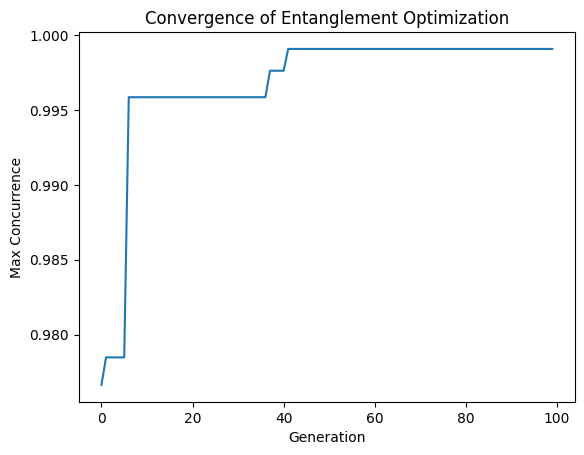

In [16]:
import jax.numpy as jnp
from jax import random, lax, jit, vmap

#paramters
n_qubits=2
pop_size=50
n_gens=100
mutation_strength=0.1
key=random.PRNGKey(0)

#initialize population
key,subkey=random.split(key)
state = random.normal(subkey,(2**n_qubits,pop_size))+1j*random.normal(subkey,(2**n_qubits,pop_size))
state=state/jnp.linalg.norm(state,axis=0)

#Concurrence for a single 2-qubit state
@jit
def compute_concurrence(state):
    a,b,c,d=state
    return 2*jnp.abs(a*d-b*c)

#vectorized concurrence across population
vectorized_concurrence=vmap(compute_concurrence,in_axes=1)

#GA step : Selection, Crossover,Mutation
@jit
def genetic_algorithm(carry,_):
    pop,key=carry
    key,subkey=random.split(key)
    #fitness(concurrence):
    concurrence=vectorized_concurrence(pop)
    #selection : top 50% of population
    n_select=pop_size//2
    if n_select % 2 != 0:
        n_select -= 1
    idx=jnp.argsort(concurrence)[::-1][:n_select]
    parents=pop[:,idx]
    #crossover : pair parents randomly
    key,subkey1,subkey2,subkey3=random.split(key,4)
    parents_idx=random.permutation(subkey1,n_select)
    half=(pop_size - n_select)  # number of children to fill remaining slots
    # choose random parent pairs for crossover
    p1_idx=random.randint(subkey2,(half,),0,n_select)
    p2_idx=random.randint(subkey3,(half,),0,n_select)
    alpha=random.uniform(subkey2,(1, half))
    parent1=parents[:,p1_idx]
    parent2=parents[:,p2_idx]
    children=alpha*parent1+(1-alpha)*parent2
    children=children/jnp.linalg.norm(children,axis=0)
    #mutation
    key,subkey=random.split(key)
    noise=mutation_strength*random.normal(subkey,(2**n_qubits,half))+1j*random.normal(subkey,(2**n_qubits,half))
    mutated=children+noise
    mutated=mutated/jnp.linalg.norm(mutated,axis=0)
    children=mutated
    #new population
    new_pop=jnp.column_stack([parents,children])
    return (new_pop,key),concurrence

#running GA
(final_pop,key),concurrence_history=lax.scan(genetic_algorithm,(state,key),None,length=n_gens)

#results
final_concurrence_values = concurrence_history[-1]
best_idx=jnp.argmax(final_concurrence_values)
best_state=final_pop[:,best_idx]
best_concurrence=final_concurrence_values[best_idx]

print(f"Best state: {best_state}")
print(f"Best concurrence: {best_concurrence}")
print(f'Max Concurrence : {jnp.max(concurrence_history)}')
print(f'Min Concurrence : {jnp.min(concurrence_history)}')

#plot convergence
import matplotlib.pyplot as plt
plt.plot(jnp.max(concurrence_history,axis=1))
plt.xlabel('Generation')
plt.ylabel('Max Concurrence')
plt.title('Convergence of Entanglement Optimization')
plt.show()